In [36]:
import pandas as pd
import numpy as np
%matplotlib inline

In [37]:
 pd.set_option('display.max_rows', 20)

## Analysis


In [38]:
df_all = pd.read_csv(r'..\data\interim\legs.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})
codes = pd.read_csv(r'..\data\processed\codes_translated.csv', dtype = {'CODE': float})

### create new variables

In [39]:
# set value of sex
code_sex = codes[codes.VARIABLE == "C2SEXO"][['CODE', 'VALUE_en']].rename({'VALUE_en': 'sex'}, axis = 1)

In [40]:
df_all = df_all.set_index('C2SEXO').join(code_sex.set_index('CODE')).reset_index()

In [41]:
# start- and endtime, duration and speed
df_all['start_time'] = pd.to_datetime(df_all.VORIHORAINI, format = '%H%M')

In [42]:
# TODO
# clean data with wrong times (TODO: how to handle 25 h properly? -> set to next weekday and start at 0h)
# wrong quick fix: set all > 24h to 24 h
df_all.loc[df_all.VDESHORAFIN == '2500', 'VDESHORAFIN'] = '2400'
df_all.loc[df_all.VDESHORAFIN == '2505', 'VDESHORAFIN'] = '2405'
df_all.loc[df_all.VDESHORAFIN == '2515', 'VDESHORAFIN'] = '2415'
df_all.loc[df_all.VDESHORAFIN == '2530', 'VDESHORAFIN'] = '2430'
df_all.loc[df_all.VDESHORAFIN == '2600', 'VDESHORAFIN'] = '2400'
df_all.loc[df_all.VDESHORAFIN == '2800', 'VDESHORAFIN'] = '2400'

In [43]:
df_all['end_time'] = pd.to_datetime(df_all.VDESHORAFIN, format = '%H%M', errors = 'coerce')
df_all['duration'] = df_all.end_time - df_all.start_time

In [44]:
df_all["speed"] = np.where(df_all.duration.dt.total_seconds() != 0, # skip if start and Endtime is the same
                       df_all.DISTANCIA_VIAJE / (df_all.duration.dt.seconds / 3600), np.NaN)

In [45]:
# simplify modal split

df_all["mode_simple"] = df_all.MODO_PRIORITARIO
df_all.loc[df_all.MODO_PRIORITARIO < 10, "mode_simple"] = "public transport"
df_all.loc[(df_all.MODO_PRIORITARIO > 9) & (df_all.MODO_PRIORITARIO < 17), "mode_simple"] = "car"
df_all.loc[(df_all.MODO_PRIORITARIO > 16) & (df_all.MODO_PRIORITARIO < 24), "mode_simple"] = "other"
df_all.loc[df_all.MODO_PRIORITARIO == 24, "mode_simple"] = "walk"

In [46]:
# dataset for single trips without legs
df = df_all.groupby(["ID_HOGAR", "ID_IND", "ID_VIAJE"]).first()

#### Average distance traveled by Sex

In [47]:
df.groupby("sex").DISTANCIA_VIAJE.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Man,101580.0,7.912443,48.427322,0.0,0.720371,2.439516,8.663173,4517.331249
Woman,121164.0,6.866701,64.050900,0.0,0.602751,1.900106,6.813408,4521.973558


**weight by ELE_G_POND_ESC2**

In [48]:
df["weighted_dist"] = df.DISTANCIA_VIAJE * df.ELE_G_POND_ESC2

In [49]:
# get the weighted mean distance
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_dist / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      7.887399
Woman    6.419492
dtype: float64

#### Average amount of trips by Sex

In [50]:
df.reset_index().groupby(["ID_HOGAR", "ID_IND", "sex"]
          ).count().reset_index().groupby("sex"
                                         ).mean().ID_VIAJE

sex
Man      2.883338
Woman    3.030767
Name: ID_VIAJE, dtype: float64

**weight by ELE_G_POND_ESC2**

In [51]:
df_ind = df.groupby(["ID_HOGAR", "ID_IND", "sex"]).ELE_G_POND_ESC2.agg(['mean', 'sum'])
df_ind_sex_sum = df_ind.groupby("sex").sum()
df_ind_sex_sum['sum'] / df_ind_sex_sum['mean']

sex
Man      2.816817
Woman    2.941150
dtype: float64

#### Modal split by sex

**full modes**

In [52]:
mode = df[["sex", "MODO_PRIORITARIO"]]

In [53]:
code_modes = codes[codes['VARIABLE'] == 'MODO_PRIORITARIO'][['CODE', 'VALUE_en']]

In [54]:
mode = df.set_index('MODO_PRIORITARIO').join(code_modes.set_index('CODE'))

In [55]:
pd.crosstab(mode.sex, mode.VALUE_en, normalize = True).T.reset_index().sort_values(by = 'Woman', ascending = False)

sex,VALUE_en,Man,Woman
17,Walking / standing ',0.144412,0.191588
21,particularly car driver ',0.151452,0.145014
22,particularly passenger car ',0.037918,0.054435
7,Meter ',0.035781,0.049775
15,Urban bus EMT Madrid ',0.022959,0.038874
...,...,...,...
1,Bicycle publishes',0.000220,0.000112
2,Bus long haul ',0.000099,0.000072
13,Scooter / moped company ',0.000049,0.000009
0,Bicycle company ',0.000004,0.000004


In [56]:
# weighted
# TODO

#### Average speed by mode and sex

In [57]:
mode = df[["sex", "MODO_PRIORITARIO", "speed"]]
mode = mode.set_index('MODO_PRIORITARIO').join(code_modes.set_index('CODE'))

In [58]:
pd.pivot_table(mode, values = 'speed', index = ['VALUE_en', 'sex'], aggfunc = ['mean', 'count']) # .sort_values(['VALUE',('count', 'speed')], ascending = False)

mean  count
                                        speed  speed
VALUE_en                     sex                    
Bicycle company '            Man     9.397481      2
                             Woman   0.629729      2
Bicycle publishes'           Man     6.960630     98
                             Woman   8.269321     50
Bus long haul '              Man    24.819488     44
...                                       ...    ...
particularly car driver '    Woman  22.152835  64514
particularly passenger car ' Man    18.382696  16870
                             Woman  21.389065  24190
passenger car business'      Man    20.187785    300
                             Woman  20.234563    302

[47 rows x 2 columns]

**aggregated modes**

In [59]:
pd.crosstab(df.sex, df.mode_simple, normalize = False).T.sort_values(by = 'Woman', ascending = False)

sex,Man,Woman
mode_simple,,
car,44352,45582
walk,32167,42675
public transport,22344,32125
other,2717,782


In [60]:
df[df.sex == 'Man'].mode_simple.value_counts(normalize = True)

car                 0.436621
walk                0.316667
public transport    0.219965
other               0.026747
Name: mode_simple, dtype: float64

In [61]:
df[df.sex == 'Woman'].mode_simple.value_counts(normalize = True)

car                 0.376201
walk                0.352209
public transport    0.265137
other               0.006454
Name: mode_simple, dtype: float64

In [62]:
pd.crosstab(df.sex, df.mode_simple, normalize = True).T.reset_index().sort_values(by = 'Woman', ascending = False)

sex,mode_simple,Man,Woman
0,car,0.199116,0.204639
3,walk,0.144412,0.191588
2,public transport,0.100312,0.144224
1,other,0.012198,0.003511


### Etapas

In [63]:
# check: multiple legs only with public transport
df.groupby(["mode_simple"]).mean().N_ETAPAS_POR_VIAJE

mode_simple
car                 1.001279
other               1.000000
public transport    1.629330
walk                1.000000
Name: N_ETAPAS_POR_VIAJE, dtype: float64

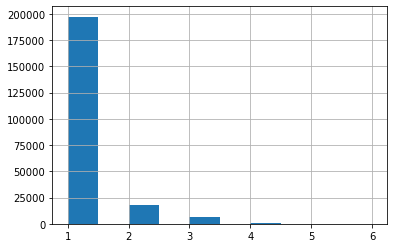

In [64]:
# how many legs (Umstiege) per trip?
df.groupby(["ID_HOGAR", "ID_IND", "ID_VIAJE"]).first().N_ETAPAS_POR_VIAJE.hist()

In [65]:
df.N_ETAPAS_POR_VIAJE.value_counts(normalize = True)

1.0    0.886120
2.0    0.078579
3.0    0.030492
4.0    0.004404
5.0    0.000386
6.0    0.000018
Name: N_ETAPAS_POR_VIAJE, dtype: float64

In [66]:
# average legs by gender
df.groupby("sex").mean().N_ETAPAS_POR_VIAJE

sex
Man      1.136011
Woman    1.169836
Name: N_ETAPAS_POR_VIAJE, dtype: float64

In [69]:
# average legs by gender only for public transport trips
df[df.mode_simple == "public transport"].groupby("sex").mean().N_ETAPAS_POR_VIAJE

sex
Man      1.616004
Woman    1.638599
Name: N_ETAPAS_POR_VIAJE, dtype: float64